In [2]:
import pandas as pd
import xarray as xr
import glob
import os
import netCDF4
import scipy
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import confusion_matrix 
from sklearn.preprocessing import scale 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
#from oceans.filters import lanc  #pip install ocean
import cartopy as cart
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.crs as ccrs

In [3]:
def low_pass_weights(window, cutoff):
    """Calculate weights for a low pass Lanczos filter.
    Args:
    window: int
        The length of the filter window.
    cutoff: float
        The cutoff frequency in inverse time steps.
    """
    order = ((window - 1) // 2 ) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k)
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma
    return w[1:-1]

In [4]:
#/nfs/public_ads/Oelsmann/marcello/gesla_v2/gesla_v2_northsea_balticsea.nc


region = 'NORTHSEA'

start_time = '01/01/2004'

end_time = '31/12/2004'

if region in {'BALTIC'} :
    max_lat = 66.0
    min_lat = 53.0
    max_lon = 31.0
    min_lon = 9.0
    
    #tg_dac = xr.open_dataset('/nfs/DGFI8/H/work_marcello/giussani_machinelearning_data/TG_DACcorrected/baltic_tg_gesla_dac.nc')
    tg_dac = xr.open_dataset('/nfs/public_ads/Oelsmann/marcello/gesla_v2/gesla_v2_northsea_balticsea.nc')

    lon = np.asarray(tg_dac.lon.values,dtype=float)
    lat = np.asarray(tg_dac.lat.values,dtype=float)    
    
#     # Exclude tide gauges in Kattegat and Skagerrag, because out of the training area

    indices =  ~( (lon < 13.0) & (lon > 9) &   \
                              (lat < 66.0) & (lat > 56.0)) & ((lon < max_lon) & (lon > min_lon) &   \
                              (lat < max_lat) & (lat > min_lat))   
    

    # Altimetry
    alti_full = pd.read_csv(r'/DGFI8/H/work_marcello/machine_learning_altimetry/test_prediction_newpoints_surge_baltic2004_01to12.csv',index_col=[0],parse_dates=[0])
    
    #model
    copernicus_full = pd.read_csv('/DGFI8/H/work_marcello/machine_learning_altimetry/test_prediction_newpoints_surge_copernicus.csv',index_col=[7],parse_dates=[7])
    copernicus_full['sla_predicted'] = copernicus_full['sla_predicted'] 

    #cmems
    cmems_full = pd.read_csv('/DGFI8/H/work_marcello/machine_learning_altimetry/test_prediction_newpoints_surge_cmems_allsat.csv',index_col=[5],parse_dates=[5])    
    

elif region in {'NORTHSEA'} :
    
    max_lat = 61.0
    min_lat = 50.0
    max_lon = 12.2
    min_lon = -4.0  
    
    tg_dac = xr.open_dataset('/nfs/public_ads/Oelsmann/marcello/gesla_v2/gesla_v2_northsea_balticsea.nc')
    
    lon = np.asarray(tg_dac.lon.values,dtype=float)
    lat = np.asarray(tg_dac.lat.values,dtype=float)
    
    indices =  ( (lon < max_lon) & (lon > min_lon) &   \
                              (lat < max_lat) & (lat > min_lat) )    

    # Altimetry
    alti_full = pd.read_csv(r'/DGFI8/H/work_marcello/machine_learning_altimetry/test_prediction_newpoints_surge_northsea2004_01to12.csv',index_col=[0],parse_dates=[0])
    
    #model
    copernicus_full = pd.read_csv('/DGFI8/H/work_marcello/machine_learning_altimetry/test_prediction_newpoints_surge_copernicus.csv',index_col=[7],parse_dates=[7])
    copernicus_full['sla_predicted'] = copernicus_full['sla_predicted'] 

    #cmems
    cmems_full = pd.read_csv('/DGFI8/H/work_marcello/machine_learning_altimetry/test_prediction_newpoints_surge_cmems_NORTHSEA_allsat.csv',index_col=[5],parse_dates=[5])



tg_dac = tg_dac.sel({'x':indices })

tg_dac


<xarray.Dataset>
Dimensions:  (time: 32677, x: 35)
Coordinates:
    lon      (x) float64 1.751 -1.875 -3.975 0.05703 ... 11.8 8.433 1.318 -2.075
    lat      (x) float64 52.47 50.71 51.57 50.78 ... 57.68 55.47 51.12 57.14
  * time     (time) datetime64[ns] 1993-01-01 1993-01-01T06:00:00 ... 2015-05-15
    index    (x) int64 ...
Dimensions without coordinates: x
Data variables:
    sla      (time, x) float64 ...
Attributes:
    info:     GESLAv2 dataset; DAC and Tide removed (with 40-h loess filter).

In [5]:
# Distance vs TG
def haversine_distance(lat1, lon1, lat2, lon2):
    r = 6371
    phi1 = np.radians(lat1)
    
    
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 -lon1)
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
    res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))

    return np.round(res, 2)

/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(12)
Coordinates:
    lon      float64 1.751
    lat      float64 52.47
    index    int64 12
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.265882  0.928203  0.799370
model  0.265882  1.000000  0.277184  0.410983
cmems  0.928203  0.277184  1.000000  0.748361
TG     0.799370  0.410983  0.748361  1.000000
RMSE ML TG
0.06277782620338418
RMSE CMEMS TG
0.07405222052178063
<xarray.DataArray 'index' ()>
array(28)
Coordinates:
    lon      float64 -3.975
    lat      float64 51.57
    index    int64 28
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000 -0.000299  0.867905  0.831627
model -0.000299  1.000000 -0.045325  0.005459
cmems  0.867905 -0.045325  1.000000  0.728521
TG     0.831627 

/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

<xarray.DataArray 'index' ()>
array(35)
Coordinates:
    lon      float64 0.05703
    lat      float64 50.78
    index    int64 35
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.094647  0.668737  0.659481
model  0.094647  1.000000  0.068853  0.105873
cmems  0.668737  0.068853  1.000000  0.527808
TG     0.659481  0.105873  0.527808  1.000000
RMSE ML TG
0.06451443623058593
RMSE CMEMS TG
0.08138310880150111


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(42)
Coordinates:
    lon      float64 0.7431
    lat      float64 51.44
    index    int64 42
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.250587  0.762645  0.660881
model  0.250587  1.000000  0.269640  0.436900
cmems  0.762645  0.269640  1.000000  0.611036
TG     0.660881  0.436900  0.611036  1.000000
RMSE ML TG
0.08858812224222701
RMSE CMEMS TG
0.09281791212097529


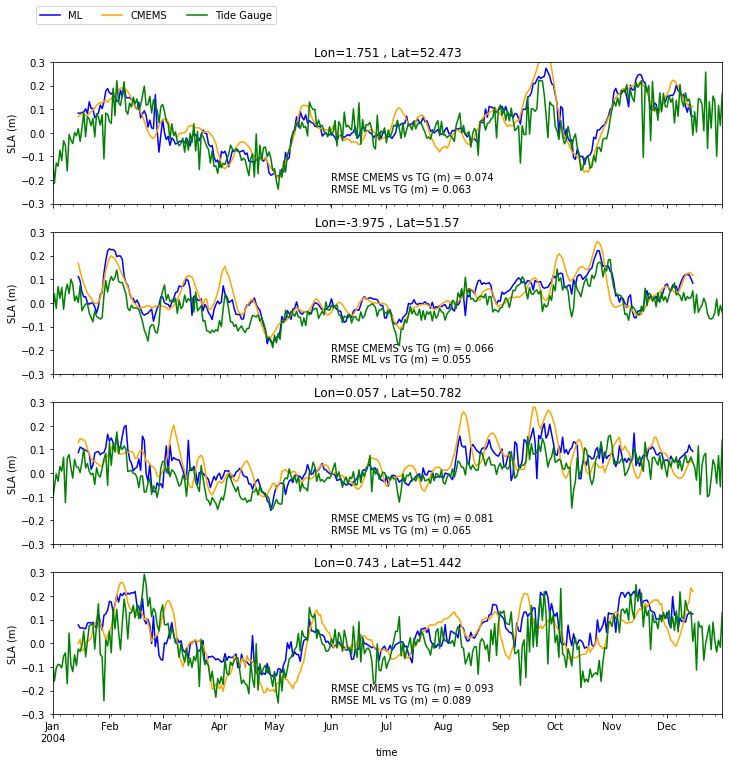

In [29]:
# FOR THE PAPER

# list_names = ['landsortnorra-010-sweden-smhi','gedser-gedser-denmark-dmi',\
#               'visby-026-sweden-smhi']

#list_names = ['skanor-019-sweden-smhi','kungsholmsfort-008-sweden-smhi',\
#              'simrishamn-017-sweden-smhi']

list_names = ['skanor-019-sweden-smhi']

corr_ML=np.empty(np.size(tg_dac.x))*np.nan
corr_cmems=np.empty(np.size(tg_dac.x))*np.nan

rms_ML=np.empty(np.size(tg_dac.x))*np.nan
rms_cmems=np.empty(np.size(tg_dac.x))*np.nan

std_ML=np.empty(np.size(tg_dac.x))*np.nan
std_cmems=np.empty(np.size(tg_dac.x))*np.nan
std_tg=np.empty(np.size(tg_dac.x))*np.nan


row_index = np.array([0,0,0])
#col_index = np.array([0,1,2])
col_index = np.arange(0,np.size(tg_dac.x))

fig, axs = plt.subplots(np.size(tg_dac.x[0:4]), 1, sharex=True, sharey=False, figsize=(12,12))

#fig_b, axs_b = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12,12))

counter = 0


#for tide_gauge_name in list_names :

for count_TG in tg_dac.x[[0,2,3,4]] :


    start_lat = np.asarray(tg_dac.lat[count_TG].values,dtype=float)
    start_lon = np.asarray(tg_dac.lon[count_TG].values,dtype=float)

    tide_gauge_name = tg_dac.index[count_TG]
    tg_due = tg_dac
    

    # initialise data of lists.
#     if region in {'BALTIC'} :
#         data = {'time':tg_due.time.values,
#                 'sla_dac':np.squeeze(tg_due.sla_dac.values)}
#     else:
    data = {'time':tg_due.time.values,
            'sla_dac':tg_due.sla[:,count_TG]}    
    #break

    # Create DataFrame
    tg = pd.DataFrame(data)
    
    # Remove mean from the tide gauge
    mean_tg_due= tg["sla_dac"].mean()
    tg.sla_dac = tg.sla_dac - tg["sla_dac"].mean()    
    median_tg_due= tg["sla_dac"].median()
    mad_tg_due= tg["sla_dac"].mad()    
    
    # Remove outliers from the tide gauge    
    tg.loc[tg["sla_dac"] > median_tg_due+1.4826*2*mad_tg_due] = np.nan
    tg.loc[tg["sla_dac"] < median_tg_due-1.4826*2*mad_tg_due] = np.nan
    
    tg=tg.set_index(tg.time)
    tg=tg.loc['2004-01-01':'2004-12-31']
    
    tg = tg.groupby(pd.Grouper(freq='24H')).mean()

    #means_tg = tg.groupby(pd.Grouper(freq='3H')).mean()
    
    

    

    #alti
    alti=alti_full.loc['2004-01-15':'2004-12-15']
    #alti_only2004=alti_only2004.loc['2004-11-20':'2004-11-29']
    copernicus=copernicus_full.loc['2004-01-15':'2004-12-15']
    cmems=cmems_full.loc['2004-01-15':'2004-12-15']
    
    

    # Compute distances from tide gauges 
    
    distances_km = haversine_distance(start_lat, start_lon, alti.lat, alti.lon)
    #distances_km_only2004 = haversine_distance(start_lat, start_lon, alti_only2004.lat, alti_only2004.lon)
    distances_km_copernicus = haversine_distance(start_lat, start_lon, copernicus.lat, copernicus.lon) 
    distances_km_cmems = haversine_distance(start_lat, start_lon, cmems.lat, cmems.lon)

    alti['distances_km']=distances_km
    #alti_only2004['distances_km']=distances_km
    copernicus['distances_km']=distances_km_copernicus
    cmems['distances_km']=distances_km_cmems

    alti.dropna(subset = ["sla_predicted"], inplace=True)
    copernicus.dropna(subset = ["sla_predicted"], inplace=True)
    cmems.dropna(subset = ["sla_predicted"], inplace=True)
    

    #alti = alti[distances_km<radius_of_distance_km]
    #copernicus = copernicus[distances_km_copernicus<radius_of_distance_km]
    #cmems = cmems[distances_km_cmems<radius_of_distance_km]
    
    
    alti = alti.loc[alti['distances_km'] == np.nanmin(alti['distances_km'])]
    copernicus = copernicus.loc[copernicus['distances_km'] == np.nanmin(copernicus['distances_km'])]
    cmems = cmems.loc[cmems['distances_km'] == np.nanmin(cmems['distances_km'])]
    #cmems = cmems.loc[np.abs(cmems['distances_km'] - np.nanmin(alti['distances_km']))<5]
    
    alti = alti.groupby(['time']).mean()
    copernicus = copernicus.groupby(['time']).mean()
    cmems = cmems.groupby(['time']).mean()
    

#     if np.shape(tg.sla_dac.values[np.isnan(tg.sla_dac.values)])[0] > 60  :
#         if counter == 0 :
#             fig.legend()        
#         counter = counter + 1
#         continue        
    
    
    freq = 1./10  # Hours
    window_size = 60


    # Plot of the products
    try:
        ref = alti.sla_predicted.plot(ax=axs[col_index[counter]],label="ML",title='lon='+str(tide_gauge_name.lon.values)+' , '+'lat='+str(tide_gauge_name.lat.values),color='blue')
    except:
        pass
    #copernicus.sla_predicted.plot(ax=axs[col_index[counter]],label="model")
    try:
        cmems.sla_predicted.plot(ax=axs[col_index[counter]],label="CMEMS",color='orange')
    except:
        pass
    tg.sla_dac.plot(ax=axs[col_index[counter]],label="Tide Gauge",color='green')  
    
    ref.text('2004-06-01',-0.25,'RMSE ML vs TG (m) = '+str( np.round( np.sqrt(((alti["sla_predicted"] - tg["sla_dac"]) ** 2).mean()),3 ) ) )
    ref.text('2004-06-01',-0.2,'RMSE CMEMS vs TG (m) = '+str( np.round( np.sqrt(((cmems["sla_predicted"] - tg["sla_dac"]) ** 2).mean()),3 ) ) )
    
    ref.set_ylabel("SLA (m)")
    
    ref.set_ylim(-0.3, 0.3)
    #ax.set_title("Title for first plot")
    ref.set_title('Lon='+str(np.round(tide_gauge_name.lon.values,3))+' , '+'Lat='+str(np.round(tide_gauge_name.lat.values,3)))
    if counter == 0 :
        fig.legend(bbox_to_anchor =(0.1, 0.95), ncol = 3,loc='upper left')
    

    
    #Correlation Analysis

    #HIGH RES

    data = [alti["sla_predicted"], copernicus["sla_predicted"], cmems["sla_predicted"], tg["sla_dac"]]

    headers = ["ML", "model", "cmems", "TG"]

    df = pd.concat(data, axis=1, keys=headers)

    #df = {'alti': np.asarray(alti.sla_predicted), 'copernicus': np.asarray(copernicus.sla_predicted), 'tg': np.asarray(tg.sealevel)}
    correlation_df = df.corr()
    print(tide_gauge_name)
    print(correlation_df)
    
    

    
    print("RMSE ML TG")
    print(np.sqrt(((alti["sla_predicted"] - tg["sla_dac"]) ** 2).mean()))
          
    print("RMSE CMEMS TG")
    print(np.sqrt(((cmems["sla_predicted"] - tg["sla_dac"]) ** 2).mean()))          
   
    corr_ML[count_TG]=correlation_df.values[0,3]
    corr_cmems[count_TG]=correlation_df.values[2,3]
    
    rms_ML[count_TG]=np.sqrt(((alti["sla_predicted"] - tg["sla_dac"]) ** 2).mean())
    rms_cmems[count_TG]=np.sqrt(((cmems["sla_predicted"] - tg["sla_dac"]) ** 2).mean())   
    
    std_ML[count_TG]=scipy.stats.iqr(alti["sla_predicted"],nan_policy='omit')#np.rms(alti["sla_predicted"]) 
    std_cmems[count_TG]=  scipy.stats.iqr(cmems["sla_predicted"],nan_policy='omit')#np.rms(cmems["sla_predicted"])
    std_tg[count_TG]=  scipy.stats.iqr(tg["sla_dac"],nan_policy='omit')#np.rms(tg["sla_dac"])    
    
    counter = counter + 1
    
    #break

fig.savefig("fig_timeseriesexample.png")





/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(12)
Coordinates:
    lon      float64 1.751
    lat      float64 52.47
    index    int64 12
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.265882  0.928203  0.799370
model  0.265882  1.000000  0.277184  0.410983
cmems  0.928203  0.277184  1.000000  0.748361
TG     0.799370  0.410983  0.748361  1.000000
RMSE ML TG
0.06277782620338418
RMSE CMEMS TG
0.07405222052178063


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(15)
Coordinates:
    lon      float64 -1.875
    lat      float64 50.71
    index    int64 15
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.064824  0.820029  0.583988
model  0.064824  1.000000  0.132551  0.187231
cmems  0.820029  0.132551  1.000000  0.552415
TG     0.583988  0.187231  0.552415  1.000000
RMSE ML TG
0.06902223300584105
RMSE CMEMS TG
0.06644206062979967


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(28)
Coordinates:
    lon      float64 -3.975
    lat      float64 51.57
    index    int64 28
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000 -0.000299  0.867905  0.831627
model -0.000299  1.000000 -0.045325  0.005459
cmems  0.867905 -0.045325  1.000000  0.728521
TG     0.831627  0.005459  0.728521  1.000000
RMSE ML TG
0.055276901117645556
RMSE CMEMS TG
0.06570096734122496


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(35)
Coordinates:
    lon      float64 0.05703
    lat      float64 50.78
    index    int64 35
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.094647  0.668737  0.659481
model  0.094647  1.000000  0.068853  0.105873
cmems  0.668737  0.068853  1.000000  0.527808
TG     0.659481  0.105873  0.527808  1.000000
RMSE ML TG
0.06451443623058593
RMSE CMEMS TG
0.08138310880150111


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(42)
Coordinates:
    lon      float64 0.7431
    lat      float64 51.44
    index    int64 42
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.250587  0.762645  0.660881
model  0.250587  1.000000  0.269640  0.436900
cmems  0.762645  0.269640  1.000000  0.611036
TG     0.660881  0.436900  0.611036  1.000000
RMSE ML TG
0.08858812224222701
RMSE CMEMS TG
0.09281791212097529


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(54)
Coordinates:
    lon      float64 12.11
    lat      float64 57.25
    index    int64 54
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.680538  0.946760  0.852073
model  0.680538  1.000000  0.646874  0.778006
cmems  0.946760  0.646874  1.000000  0.805116
TG     0.852073  0.778006  0.805116  1.000000
RMSE ML TG
0.05992185633782224
RMSE CMEMS TG
0.07150526997545785


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

<xarray.DataArray 'index' ()>
array(73)
Coordinates:
    lon      float64 -1.44
    lat      float64 55.01
    index    int64 73
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.367001  0.962298  0.848287
model  0.367001  1.000000  0.374772  0.375842
cmems  0.962298  0.374772  1.000000  0.847458
TG     0.848287  0.375842  0.847458  1.000000
RMSE ML TG
0.04666644567102581
RMSE CMEMS TG
0.04592120030535527


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(107)
Coordinates:
    lon      float64 -0.186
    lat      float64 53.63
    index    int64 107
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.339865  0.929936  0.755915
model  0.339865  1.000000  0.322708  0.487090
cmems  0.929936  0.322708  1.000000  0.695534
TG     0.755915  0.487090  0.695534  1.000000
RMSE ML TG
0.07643701486855982
RMSE CMEMS TG
0.08448719705666657


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(110)
Coordinates:
    lon      float64 -2.92
    lat      float64 54.03
    index    int64 110
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.161260  0.853767  0.628772
model  0.161260  1.000000  0.149838  0.035817
cmems  0.853767  0.149838  1.000000  0.538530
TG     0.628772  0.035817  0.538530  1.000000
RMSE ML TG
0.12405081053378161
RMSE CMEMS TG
0.14326034748788338


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(114)
Coordinates:
    lon      float64 8.717
    lat      float64 53.87
    index    int64 114
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.138472  0.840204  0.754102
model  0.138472  1.000000  0.122971  0.117685
cmems  0.840204  0.122971  1.000000  0.676184
TG     0.754102  0.117685  0.676184  1.000000
RMSE ML TG
0.11601765581508419
RMSE CMEMS TG
0.1323595316981962


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(140)
Coordinates:
    lon      float64 2.367
    lat      float64 51.05
    index    int64 140
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.131532  0.666049  0.680983
model  0.131532  1.000000  0.058647  0.146273
cmems  0.666049  0.058647  1.000000  0.481443
TG     0.680983  0.146273  0.481443  1.000000
RMSE ML TG
0.09060689328755132
RMSE CMEMS TG
0.11398192407716826


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(174)
Coordinates:
    lon      float64 10.73
    lat      float64 59.91
    index    int64 174
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.540468  0.928026  0.751559
model  0.540468  1.000000  0.624231  0.702360
cmems  0.928026  0.624231  1.000000  0.782374
TG     0.751559  0.702360  0.782374  1.000000
RMSE ML TG
0.07165777559891492
RMSE CMEMS TG
0.07125989953824768


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(194)
Coordinates:
    lon      float64 -3.134
    lat      float64 51.22
    index    int64 194
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000 -0.000299  0.867905  0.702516
model -0.000299  1.000000 -0.045325 -0.118798
cmems  0.867905 -0.045325  1.000000  0.619525
TG     0.702516 -0.118798  0.619525  1.000000
RMSE ML TG
0.06290241880077022
RMSE CMEMS TG
0.07146866467452806


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(200)
Coordinates:
    lon      float64 11.22
    lat      float64 58.35
    index    int64 200
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.552791  0.951030  0.789143
model  0.552791  1.000000  0.560941  0.619374
cmems  0.951030  0.560941  1.000000  0.778928
TG     0.789143  0.619374  0.778928  1.000000
RMSE ML TG
0.05876561819007579
RMSE CMEMS TG
0.060710974350550624


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(205)
Coordinates:
    lon      float64 11.93
    lat      float64 54.57
    index    int64 205
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.654157  0.866044  0.723250
model  0.654157  1.000000  0.784766  0.881444
cmems  0.866044  0.784766  1.000000  0.883471
TG     0.723250  0.881444  0.883471  1.000000
RMSE ML TG
0.09722467657181107
RMSE CMEMS TG
0.06645515875992894


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(225)
Coordinates:
    lon      float64 7.555
    lat      float64 58.01
    index    int64 225
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.505006  0.885543  0.600180
model  0.505006  1.000000  0.460871  0.450698
cmems  0.885543  0.460871  1.000000  0.634469
TG     0.600180  0.450698  0.634469  1.000000
RMSE ML TG
0.06758421256947283
RMSE CMEMS TG
0.060177283465954017


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(249)
Coordinates:
    lon      float64 -1.14
    lat      float64 60.16
    index    int64 249
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.470187  0.959052  0.855647
model  0.470187  1.000000  0.441427  0.367207
cmems  0.959052  0.441427  1.000000  0.841842
TG     0.855647  0.367207  0.841842  1.000000
RMSE ML TG
0.035516514243644125
RMSE CMEMS TG
0.03843404154603521


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(251)
Coordinates:
    lon      float64 11.13
    lat      float64 59.0
    index    int64 251
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.551633  0.925372  0.745852
model  0.551633  1.000000  0.641040  0.694319
cmems  0.925372  0.641040  1.000000  0.774186
TG     0.745852  0.694319  0.774186  1.000000
RMSE ML TG
0.06730922957285257
RMSE CMEMS TG
0.06483041286312821


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(265)
Coordinates:
    lon      float64 1.302
    lat      float64 52.93
    index    int64 265
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.324254  0.899803  0.808361
model  0.324254  1.000000  0.277671  0.374401
cmems  0.899803  0.277671  1.000000  0.719854
TG     0.808361  0.374401  0.719854  1.000000
RMSE ML TG
0.07184807004129093
RMSE CMEMS TG
0.08769942329855773


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(268)
Coordinates:
    lon      float64 -0.6142
    lat      float64 54.49
    index    int64 268
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.367962  0.957375  0.862829
model  0.367962  1.000000  0.354204  0.270335
cmems  0.957375  0.354204  1.000000  0.832623
TG     0.862829  0.270335  0.832623  1.000000
RMSE ML TG
0.06966427823886297
RMSE CMEMS TG
0.07132293427701401


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(278)
Coordinates:
    lon      float64 11.83
    lat      float64 58.09
    index    int64 278
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.556409  0.933708  0.782901
model  0.556409  1.000000  0.582503  0.569428
cmems  0.933708  0.582503  1.000000  0.760173
TG     0.782901  0.569428  0.760173  1.000000
RMSE ML TG
0.0829053601606813
RMSE CMEMS TG
0.0861405397735462


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(281)
Coordinates:
    lon      float64 4.746
    lat      float64 52.97
    index    int64 281
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.190560  0.876803  0.753322
model  0.190560  1.000000  0.161645  0.064784
cmems  0.876803  0.161645  1.000000  0.684851
TG     0.753322  0.064784  0.684851  1.000000
RMSE ML TG
0.0802376283190926
RMSE CMEMS TG
0.09806361274213332


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(291)
Coordinates:
    lon      float64 1.348
    lat      float64 51.96
    index    int64 291
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.249802  0.731383  0.752231
model  0.249802  1.000000  0.269640  0.378602
cmems  0.731383  0.269640  1.000000  0.648238
TG     0.752231  0.378602  0.648238  1.000000
RMSE ML TG
0.08199517298922149
RMSE CMEMS TG
0.08796956706878471


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

<xarray.DataArray 'index' ()>
array(304)
Coordinates:
    lon      float64 1.868
    lat      float64 50.97
    index    int64 304
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.109915  0.697757  0.592228
model  0.109915  1.000000  0.058647  0.091977
cmems  0.697757  0.058647  1.000000  0.453463
TG     0.592228  0.091977  0.453463  1.000000
RMSE ML TG
0.09790408178120748
RMSE CMEMS TG
0.11780559890268993


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(351)
Coordinates:
    lon      float64 -2.987
    lat      float64 51.55
    index    int64 351
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000 -0.000299  0.867905  0.568910
model -0.000299  1.000000 -0.045325 -0.134235
cmems  0.867905 -0.045325  1.000000  0.513041
TG     0.568910 -0.134235  0.513041  1.000000
RMSE ML TG
0.10614614044070309
RMSE CMEMS TG
0.1115484352570159


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(369)
Coordinates:
    lon      float64 -3.086
    lat      float64 58.44
    index    int64 369
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.477232  0.936689  0.876072
model  0.477232  1.000000  0.408216  0.506052
cmems  0.936689  0.408216  1.000000  0.859829
TG     0.876072  0.506052  0.859829  1.000000
RMSE ML TG
0.03557076752415012
RMSE CMEMS TG
0.03947578775948389


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(373)
Coordinates:
    lon      float64 4.12
    lat      float64 51.98
    index    int64 373
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.213937  0.820282  0.736103
model  0.213937  1.000000  0.215284  0.137205
cmems  0.820282  0.215284  1.000000  0.622049
TG     0.736103  0.137205  0.622049  1.000000
RMSE ML TG
0.08076281521101306
RMSE CMEMS TG
0.10434901918111396


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(390)
Coordinates:
    lon      float64 6.933
    lat      float64 53.33
    index    int64 390
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.193090  0.865692  0.732552
model  0.193090  1.000000  0.147795  0.134454
cmems  0.865692  0.147795  1.000000  0.652908
TG     0.732552  0.134454  0.652908  1.000000
RMSE ML TG
0.10391008869597414
RMSE CMEMS TG
0.12092685238279367


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(409)
Coordinates:
    lon      float64 1.578
    lat      float64 50.73
    index    int64 409
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.047788  0.701060  0.531735
model  0.047788  1.000000 -0.017363  0.018675
cmems  0.701060 -0.017363  1.000000  0.383702
TG     0.531735  0.018675  0.383702  1.000000
RMSE ML TG
0.088588632075834
RMSE CMEMS TG
0.11349910629397258


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(411)
Coordinates:
    lon      float64 11.8
    lat      float64 57.68
    index    int64 411
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.662066  0.944822  0.843107
model  0.662066  1.000000  0.648724  0.746839
cmems  0.944822  0.648724  1.000000  0.824105
TG     0.843107  0.746839  0.824105  1.000000
RMSE ML TG
0.057282260666474266
RMSE CMEMS TG
0.06254434002338957


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(449)
Coordinates:
    lon      float64 8.433
    lat      float64 55.47
    index    int64 449
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.124144  0.900898  0.817531
model  0.124144  1.000000  0.080967  0.007287
cmems  0.900898  0.080967  1.000000  0.848489
TG     0.817531  0.007287  0.848489  1.000000
RMSE ML TG
0.10063378635429321
RMSE CMEMS TG
0.08839743519536894


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(456)
Coordinates:
    lon      float64 1.318
    lat      float64 51.12
    index    int64 456
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.109915  0.697757  0.609133
model  0.109915  1.000000  0.058647  0.196604
cmems  0.697757  0.058647  1.000000  0.473211
TG     0.609133  0.196604  0.473211  1.000000
RMSE ML TG
0.09025094970852103
RMSE CMEMS TG
0.11083052212563654


/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/passaro/anaconda3/envs/machine_learning_altimetry_validation/lib/python3.6/site-packages/ipykernel_launcher.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<xarray.DataArray 'index' ()>
array(478)
Coordinates:
    lon      float64 -2.075
    lat      float64 57.14
    index    int64 478
Attributes:
    standard_name:  index
    long_name:      index tg (to related to the GESLA database)
    units:          
             ML     model     cmems        TG
ML     1.000000  0.667196  0.947230  0.871385
model  0.667196  1.000000  0.685199  0.681056
cmems  0.947230  0.685199  1.000000  0.811745
TG     0.871385  0.681056  0.811745  1.000000
RMSE ML TG
0.042192191267868946
RMSE CMEMS TG
0.04912297719938032


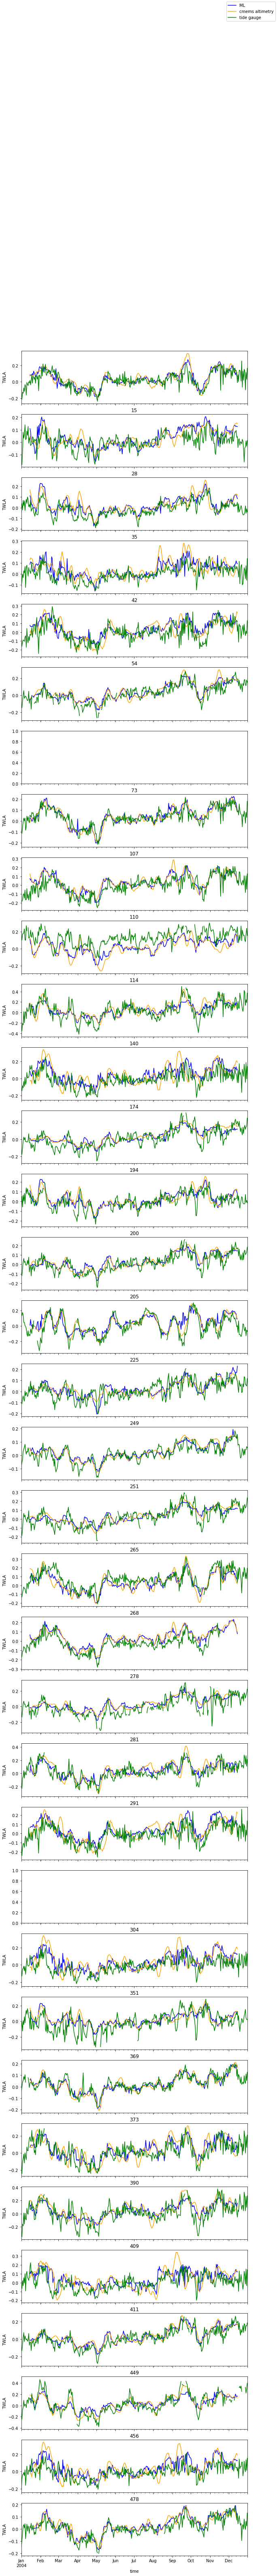

In [81]:
# list_names = ['landsortnorra-010-sweden-smhi','gedser-gedser-denmark-dmi',\
#               'visby-026-sweden-smhi']

#list_names = ['skanor-019-sweden-smhi','kungsholmsfort-008-sweden-smhi',\
#              'simrishamn-017-sweden-smhi']

list_names = ['skanor-019-sweden-smhi']

corr_ML=np.empty(np.size(tg_dac.x))*np.nan
corr_cmems=np.empty(np.size(tg_dac.x))*np.nan

rms_ML=np.empty(np.size(tg_dac.x))*np.nan
rms_cmems=np.empty(np.size(tg_dac.x))*np.nan

std_ML=np.empty(np.size(tg_dac.x))*np.nan
std_cmems=np.empty(np.size(tg_dac.x))*np.nan
std_tg=np.empty(np.size(tg_dac.x))*np.nan


row_index = np.array([0,0,0])
#col_index = np.array([0,1,2])
col_index = np.arange(0,np.size(tg_dac.x))

fig, axs = plt.subplots(np.size(tg_dac.x), 1, sharex=True, sharey=False, figsize=(10,100))

#fig_b, axs_b = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12,12))

counter = 0


#for tide_gauge_name in list_names :

for count_TG in tg_dac.x[0:] :

    #radius_of_distance_km = 100
    #tide_gauge_name='visby-026-sweden-smhi'
    
    start_lat = np.asarray(tg_dac.lat[count_TG].values,dtype=float)
    start_lon = np.asarray(tg_dac.lon[count_TG].values,dtype=float)

#     if region in {'BALTIC'} :
#         tide_gauge_name = tg_dac.name[count_TG]
#         tg_due = tg_dac.where(tg_dac.name==tide_gauge_name, drop=True)
#         tide_gauge_name = tg_dac.name[count_TG]
#     else:
    tide_gauge_name = tg_dac.index[count_TG]
    tg_due = tg_dac
    

    ## TIDE CORRECTION

    # dates = []

    # for j in range(-1,24*28*365+5):
    #      dates.append(np.array([datetime(1993, 1, 1, 0, 0, 0) + 
    # timedelta(hours=1+j)]))

    # dates = np.ravel(dates)

    # plt.figure(figsize=(15,5),dpi=320)

    # tide_correction_fes = pd.read_csv("/DGFI8/H/work_marcello/giussani_machinelearning_data/TG/landsortnorra-010-sweden-smhi_fes_ocean.txt",header=None)/100

    # plt.plot(dates,tide_correction_fes,)

    # plt.plot(tg_due.date_time,tg_due.sealevel-tide_correction_fes)
    # plt.ylabel('m')




    # initialise data of lists.
#     if region in {'BALTIC'} :
#         data = {'time':tg_due.time.values,
#                 'sla_dac':np.squeeze(tg_due.sla_dac.values)}
#     else:
    data = {'time':tg_due.time.values,
            'sla_dac':tg_due.sla[:,count_TG]}    
    #break

    # Create DataFrame
    tg = pd.DataFrame(data)
    
    # Remove mean from the tide gauge
    mean_tg_due= tg["sla_dac"].mean()
    tg.sla_dac = tg.sla_dac - tg["sla_dac"].mean()    
    median_tg_due= tg["sla_dac"].median()
    mad_tg_due= tg["sla_dac"].mad()    
    
    # Remove outliers from the tide gauge    
    tg.loc[tg["sla_dac"] > median_tg_due+1.4826*2*mad_tg_due] = np.nan
    tg.loc[tg["sla_dac"] < median_tg_due-1.4826*2*mad_tg_due] = np.nan
    
    tg=tg.set_index(tg.time)
    tg=tg.loc['2004-01-01':'2004-12-31']
    
    tg = tg.groupby(pd.Grouper(freq='24H')).mean()

    #means_tg = tg.groupby(pd.Grouper(freq='3H')).mean()
    
    

    

    #alti
    alti=alti_full.loc['2004-01-15':'2004-12-15']
    #alti_only2004=alti_only2004.loc['2004-11-20':'2004-11-29']
    copernicus=copernicus_full.loc['2004-01-15':'2004-12-15']
    cmems=cmems_full.loc['2004-01-15':'2004-12-15']
    
    

    # Compute distances from tide gauges 
    
    distances_km = haversine_distance(start_lat, start_lon, alti.lat, alti.lon)
    #distances_km_only2004 = haversine_distance(start_lat, start_lon, alti_only2004.lat, alti_only2004.lon)
    distances_km_copernicus = haversine_distance(start_lat, start_lon, copernicus.lat, copernicus.lon) 
    distances_km_cmems = haversine_distance(start_lat, start_lon, cmems.lat, cmems.lon)

    alti['distances_km']=distances_km
    #alti_only2004['distances_km']=distances_km
    copernicus['distances_km']=distances_km_copernicus
    cmems['distances_km']=distances_km_cmems

    alti.dropna(subset = ["sla_predicted"], inplace=True)
    copernicus.dropna(subset = ["sla_predicted"], inplace=True)
    cmems.dropna(subset = ["sla_predicted"], inplace=True)
    

    #alti = alti[distances_km<radius_of_distance_km]
    #copernicus = copernicus[distances_km_copernicus<radius_of_distance_km]
    #cmems = cmems[distances_km_cmems<radius_of_distance_km]
    
    
    alti = alti.loc[alti['distances_km'] == np.nanmin(alti['distances_km'])]
    copernicus = copernicus.loc[copernicus['distances_km'] == np.nanmin(copernicus['distances_km'])]
    cmems = cmems.loc[cmems['distances_km'] == np.nanmin(cmems['distances_km'])]
    #cmems = cmems.loc[np.abs(cmems['distances_km'] - np.nanmin(alti['distances_km']))<5]
    
    

#     alti = alti.loc[alti['distances_km'] <20]
#     copernicus = copernicus.loc[copernicus['distances_km'] <20]
#     cmems = cmems.loc[cmems['distances_km'] <20]
 
    
    #alti = alti.iloc[[np.nanargmin(distances_km)]]
    #copernicus = copernicus.iloc[[np.nanargmin(distances_km_copernicus)]]
    #cmems = cmems.iloc[[np.nanargmin(distances_km_cmems)]]


    alti = alti.groupby(['time']).mean()
    copernicus = copernicus.groupby(['time']).mean()
    cmems = cmems.groupby(['time']).mean()
    
    
    #Check that time series are not too short and that they have a similar number of data
#     if np.shape(alti)[0] < 120 or np.shape(cmems)[0] < 120 or np.shape(tg.sla_dac)[0]<120 or np.shape(tg.sla_dac.values[np.isnan(tg.sla_dac.values)])[0] > 60  :
#         if counter == 0 :
#             fig.legend()        
#         counter = counter + 1
#         continue
        
    if np.shape(tg.sla_dac.values[np.isnan(tg.sla_dac.values)])[0] > 60  :
        if counter == 0 :
            fig.legend()        
        counter = counter + 1
        continue        
    
    
    freq = 1./10  # Hours
    window_size = 60
    


    
    # LOESS FILTER IN TIME
#     lowess_sm = sm.nonparametric.lowess
#     points_to_filter = 10 #100 points along-track correspond to about 60 km
#     frac_loess = points_to_filter/np.size(alti.sla_predicted)
#     alti.sla_predicted = lowess_sm(np.asarray(alti.sla_predicted),np.asarray(alti.times),frac=frac_loess,it=3, return_sorted = False,missing='drop')
#     cmems.sla_predicted = lowess_sm(np.asarray(cmems.sla_predicted),np.asarray(cmems.times),frac=frac_loess,it=3, return_sorted = False,missing='drop')
    

    # Oversample daily cmems to hourly values
    #cmems_oversample = cmems
    #cmems_oversample = cmems.resample('3H').pad()
    
    
#     means_alti = alti.groupby(pd.Grouper(freq='24H')).mean()
#     means_alti.sla_predicted = np.convolve(means_alti.sla_predicted, np.ones(7)/7, mode='same')
    
#     means_copernicus  = copernicus.groupby(pd.Grouper(freq='24H')).mean()
#     means_cmems  = cmems.groupby(pd.Grouper(freq='24H')).mean()
#     means_tg = tg.groupby(pd.Grouper(freq='24H')).mean()    
    

    # Plot of the products
    try:
        ref = alti.sla_predicted.plot(ax=axs[col_index[counter]],label="ML",title=tide_gauge_name.values,color='blue')
    except:
        pass
    #copernicus.sla_predicted.plot(ax=axs[col_index[counter]],label="model")
    try:
        cmems.sla_predicted.plot(ax=axs[col_index[counter]],label="cmems altimetry",color='orange')
    except:
        pass
    tg.sla_dac.plot(ax=axs[col_index[counter]],label="tide gauge",color='green')  
    ref.set_ylabel("TWLA")
    if counter == 0 :
        fig.legend()
    
    
    
    


    # Plot of the daily products
#     means_alti.sla_predicted.plot(ax=axs[row_index[counter],col_index[counter]],label="ML")
#     means_copernicus.sla_predicted.plot(ax=axs[row_index[counter],col_index[counter]],label="model")
#     means_cmems.sla_predicted.plot(ax=axs[row_index[counter],col_index[counter]],label="cmems altimetry")
#     means_tg.sealevel.plot(ax=axs[row_index[counter],col_index[counter]],label="tide gauge")
#     if counter == 0 :
#         fig.legend()
    
    
    
    #Correlation Analysis

    #HIGH RES

    data = [alti["sla_predicted"], copernicus["sla_predicted"], cmems["sla_predicted"], tg["sla_dac"]]

    headers = ["ML", "model", "cmems", "TG"]

    df = pd.concat(data, axis=1, keys=headers)

    #df = {'alti': np.asarray(alti.sla_predicted), 'copernicus': np.asarray(copernicus.sla_predicted), 'tg': np.asarray(tg.sealevel)}
    correlation_df = df.corr()
    print(tide_gauge_name)
    print(correlation_df)
    
    

    
    print("RMSE ML TG")
    print(np.sqrt(((alti["sla_predicted"] - tg["sla_dac"]) ** 2).mean()))
          
    print("RMSE CMEMS TG")
    print(np.sqrt(((cmems["sla_predicted"] - tg["sla_dac"]) ** 2).mean()))          
   
    corr_ML[count_TG]=correlation_df.values[0,3]
    corr_cmems[count_TG]=correlation_df.values[2,3]
    
    rms_ML[count_TG]=np.sqrt(((alti["sla_predicted"] - tg["sla_dac"]) ** 2).mean())
    rms_cmems[count_TG]=np.sqrt(((cmems["sla_predicted"] - tg["sla_dac"]) ** 2).mean())  
    
#     stddiff_ML[count_TG]=np.std(alti["sla_predicted"]) - np.std(tg["sla_dac"]) 
#     stddiff_cmems[count_TG]=  np.std(cmems["sla_predicted"]) - np.std(tg["sla_dac"])    
    
    std_ML[count_TG]=scipy.stats.iqr(alti["sla_predicted"],nan_policy='omit')#np.rms(alti["sla_predicted"]) 
    std_cmems[count_TG]=  scipy.stats.iqr(cmems["sla_predicted"],nan_policy='omit')#np.rms(cmems["sla_predicted"])
    std_tg[count_TG]=  scipy.stats.iqr(tg["sla_dac"],nan_policy='omit')#np.rms(tg["sla_dac"])    
    
    counter = counter + 1
    
    #break
    

Mean difference in correlation ML - CMEMS (%)
9.742733407040738
Mean difference in RMS ML - CMEMS (%)
-7.5537895526906444


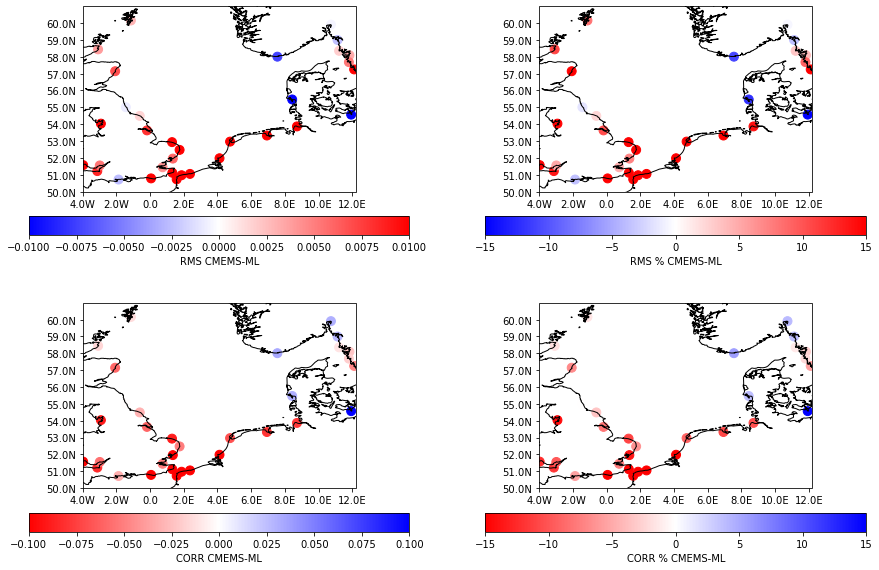

In [82]:
# FUNCTION TO PLOT SINGLE INSTANTANEOUS MAPS -  to be externalised

def single_plot(rms_cmemsvsML_plot,min_sl,max_sl,counter,row_total,col_total,fig,min_lat,max_lat,min_lon,max_lon,label_string,colormap):

    lon = rms_cmemsvsML_plot[0,:]
    lat = rms_cmemsvsML_plot[1,:]
    ssh = rms_cmemsvsML_plot[2,:]   
    
    """Displaying the unstructured grid in a scatterplot:"""
    # 

    #fig = plt.plot()
    #plt.rcParams.update({'font.size': 15})
    #plt.plot
    #plt.rcParams["figure.figsize"] = (50,10) #Increase figure size
    ax=fig.add_subplot(row_total,col_total,counter,projection=ccrs.PlateCarree())
    
    ax.set_xticks(np.arange(min_lon,max_lon,2), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(min_lat,max_lat,1), crs=ccrs.PlateCarree())    
    
    #ax = plt.axes(projection=ccrs.Miller()) 
    img=plt.scatter(lon, lat, c=ssh, s=80, cmap=colormap, alpha=1) 
    ax.coastlines(resolution='10m', color='black', linewidth=1) 
    plt.xlim(min_lon,max_lon)

    lon_formatter = cart.mpl.ticker.LongitudeFormatter(number_format='.1f', 
                                      degree_symbol='', 
                                      dateline_direction_label=True)
    lat_formatter = cart.mpl.ticker.LatitudeFormatter(number_format='.1f', 
                                     degree_symbol='')
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter) 
    plt.colorbar(img,label=label_string,orientation = 'horizontal',pad = 0.1)
    plt.clim(min_sl, max_sl)
    
    ax.set_extent([min_lon,max_lon,min_lat,max_lat,])
    #plt.show() #a window will show up, allowing the user to see and download the plot
    
    return 







# Absolute differences in RMS, Correlation and standard deviation
rms_cmemsvsML_plot=np.vstack([np.asarray(tg_dac.lon.values,dtype=float),np.asarray(tg_dac.lat.values,dtype=float),rms_cmems-rms_ML,])
corr_cmemsvsML_plot=np.vstack([np.asarray(tg_dac.lon.values,dtype=float),np.asarray(tg_dac.lat.values,dtype=float),corr_cmems-corr_ML,])

# Percentage differences in RMS and Correlation
rms_pc_cmemsvsML_plot=np.vstack([np.asarray(tg_dac.lon.values,dtype=float),np.asarray(tg_dac.lat.values,dtype=float),((rms_cmems-rms_ML)/rms_ML)*100,])
corr_pc_cmemsvsML_plot=np.vstack([np.asarray(tg_dac.lon.values,dtype=float),np.asarray(tg_dac.lat.values,dtype=float),((corr_cmems-corr_ML)/corr_ML)*100,])


fig = plt.figure(figsize = (15, 10))

min_sl = -0.01
max_sl = 0.01
single_plot(rms_cmemsvsML_plot,min_sl,max_sl,1,2,2,fig,min_lat,max_lat,min_lon,max_lon,r'RMS CMEMS-ML','bwr')

min_sl = -15
max_sl = 15
single_plot(rms_pc_cmemsvsML_plot,min_sl,max_sl,2,2,2,fig,min_lat,max_lat,min_lon,max_lon,r'RMS % CMEMS-ML','bwr')

if region in {'BALTIC'} :
    min_sl = -0.05
    max_sl = 0.05
elif region in {'NORTHSEA'} :  
    min_sl = -0.10
    max_sl = 0.10    
    
single_plot(corr_cmemsvsML_plot,min_sl,max_sl,3,2,2,fig,min_lat,max_lat,min_lon,max_lon,r'CORR CMEMS-ML','bwr_r')

if region in {'BALTIC'} :
    min_sl = -5
    max_sl = 5
elif region in {'NORTHSEA'} :
    min_sl = -15
    max_sl = 15
single_plot(corr_pc_cmemsvsML_plot,min_sl,max_sl,4,2,2,fig,min_lat,max_lat,min_lon,max_lon,r'CORR % CMEMS-ML','bwr_r')


# Correlation
print('Mean difference in correlation ML - CMEMS (%)')
print(np.nanmean((corr_ML - corr_cmems) / corr_cmems * 100))

# RMS
print('Mean difference in RMS ML - CMEMS (%)')
print(np.nanmean((rms_ML - rms_cmems) / rms_cmems *100))


Average misrepresented signal in ML (%)
2.690009403888654
Average misrepresented signal in CMEMS (%)
6.086924836394403


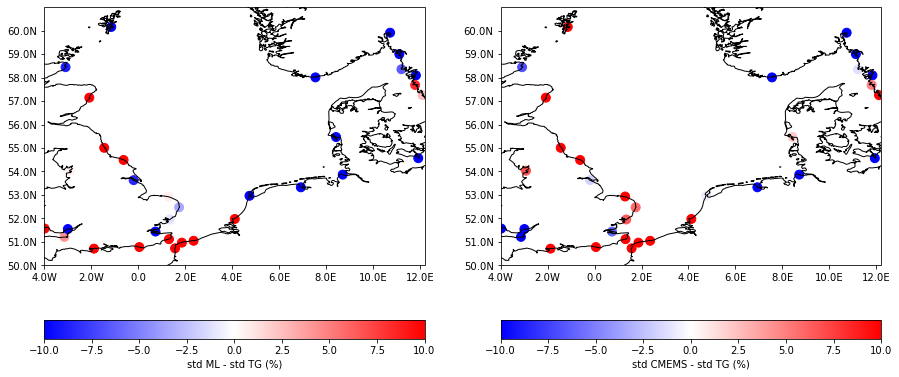

In [83]:
#Standard Deviations

stddiff_ML_plot=np.vstack([np.asarray(tg_dac.lon.values,dtype=float),np.asarray(tg_dac.lat.values,dtype=float),(std_ML-std_tg)/std_tg *100,])

stddiff_cmems_plot=np.vstack([np.asarray(tg_dac.lon.values,dtype=float),np.asarray(tg_dac.lat.values,dtype=float),(std_cmems-std_tg)/std_tg *100,])


fig = plt.figure(figsize = (15, 10))

min_sl = -10
max_sl = 10
single_plot(stddiff_ML_plot ,min_sl,max_sl,1,1,2,fig,min_lat,max_lat,min_lon,max_lon,r'std ML - std TG (%)','bwr')


single_plot(stddiff_cmems_plot,min_sl,max_sl,2,1,2,fig,min_lat,max_lat,min_lon,max_lon,r'std CMEMS - std TG (%)','bwr')


print('Average misrepresented signal in ML (%)')
print(np.nanmean( (std_ML-std_tg)/std_tg *100)) 

print('Average misrepresented signal in CMEMS (%)')
print(np.nanmean( (std_cmems-std_tg)/std_tg *100) )




#### 

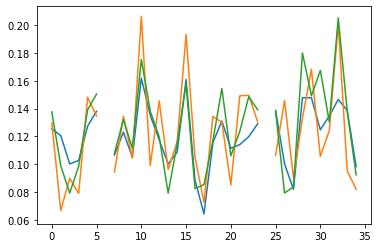

In [86]:
plt.plot(std_ML)
plt.plot(std_tg)
plt.plot(std_cmems)